In [1]:
# !pip install scikit-survival
# !pip install lifelines scikit-survival statsmodels
import pandas as pd
import numpy as np
import lifelines
from lifelines import CoxPHFitter, KaplanMeierFitter
from sksurv.metrics import cumulative_dynamic_auc
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_chisquare
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.util import Surv
from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
import warnings
warnings.filterwarnings('ignore')

## Reading Dataset

In [2]:
df_original = pd.read_csv('./data.csv')

print(f'METABRIC Dataset Shape: {df_original.shape}')
print(f'METABRIC Dataset Memory Usage: {df_original.memory_usage().sum() / 1024 ** 2:.2f} MB')

METABRIC Dataset Shape: (1904, 693)
METABRIC Dataset Memory Usage: 10.07 MB


In [3]:
selected_columns = df_original[['overall_survival', 'overall_survival_months'] + list(df_original.columns[31:])]
selected_columns.head(2)

,overall_survival,overall_survival_months,brca1,brca2,palb2,pten,tp53,atm,cdh1,chek2,...,mtap_mut,ppp2cb_mut,smarcd1_mut,nras_mut,ndfip1_mut,hras_mut,prps2_mut,smarcb1_mut,stmn2_mut,siah1_mut
0,1,140.500000,-1.399,-0.5738,-1.6217,1.4524,0.3504,1.1517,0.0348,0.1266,...,0,0,0,0,0,0,0,0,0,0
1,1,84.633333,-1.380,0.2777,-1.2154,0.5296,-0.0136,-0.2659,1.3594,0.7961,...,0,0,0,0,0,0,0,0,0,0


## Univariate Cox Model:
- identify mRNA genetic attributes that are significantly related to survival (p < 0.000001)

In [4]:
cph = CoxPHFitter()
significant_mrnas = []
for column in selected_columns.columns:
    if column != 'overall_survival' or column != 'overall_survival_months':

        df = selected_columns[['overall_survival_months','overall_survival', column]].dropna()
        df = df.rename(columns={column:'mRNA expression'})
        # Fit the Cox model
        try: 
            cph.fit(df, duration_col='overall_survival_months',event_col='overall_survival')
            p_value = cph.summary.loc['mRNA expression','p']
            if p_value < 0.000001:
                significant_mrnas.append(column)
#                 significant_mrnas.append([column, p_value])
#                 print(f"{column} is significantly associated with survival(p = {p_value:.3e})")
        except Exception as e:
            continue
    
print(significant_mrnas[:10])

['brca1', 'brca2', 'palb2', 'pten', 'tp53', 'atm', 'cdh1', 'chek2', 'nbn', 'nf1']


## Multivariate Cox Model:
- identify mRNA genetric attributes and their weights / coef

In [5]:
genes_of_interest = ['hsd17b11', 'cdkn2c', 'jak1', 'gsk3b', 'spry2', 'lama2', 'kmt2c', 'casp8', 'tgfbr2', 'map4', 'abcb1', 'kit', 'tsc2', 'pdgfra', 'igf1', 'tnk2', 'myc', 'stat5a', 'smad4', 'ccnd2', 'rps6', 'pdgfb', 'jak2', 'rheb', 'ncoa3', 'akt1']
significant_df = selected_columns[['overall_survival', 'overall_survival_months'] + list(selected_columns[genes_of_interest])]
significant_df.head(2)

,overall_survival,overall_survival_months,hsd17b11,cdkn2c,jak1,gsk3b,spry2,lama2,kmt2c,casp8,...,myc,stat5a,smad4,ccnd2,rps6,pdgfb,jak2,rheb,ncoa3,akt1
0,1,140.500000,1.6822,6.4965,1.1097,-0.7982,2.8796,2.6466,-0.9045,0.1816,...,2.5602,3.9189,0.2348,1.4313,0.8191,-0.0349,1.6186,0.7390,-0.2318,-1.1280
1,1,84.633333,-0.7837,0.5189,0.9804,-0.0094,0.2446,0.3336,-0.0208,1.8819,...,0.7248,-0.4983,0.8578,0.0546,1.4198,-0.3739,-0.0104,0.7496,-0.0219,0.0312


In [6]:
# Fit the model
cph = CoxPHFitter()
cph.fit(significant_df, 'overall_survival_months', event_col='overall_survival')
cph.print_summary()  

# Access the individual results for each mRNA
for mrna in significant_df.columns[2:]:
    hr = cph.hazard_ratios_[mrna]
    p_value = cph.summary.loc[mrna, 'p']
    ci_lower = cph.confidence_intervals_.loc[mrna, '95% lower-bound']
    ci_upper = cph.confidence_intervals_.loc[mrna, '95% upper-bound']
#     print(f"{mrna}: HR = {hr:.3f}, p-value = {p_value:.3e}, 95% CI = ({ci_lower:.3f}, {ci_upper:.3f})")

# print(f"Model AIC: {cph.AIC_partial_:.2f}")


<lifelines.CoxPHFitter: fitted with 1904 total observations, 1103 right-censored observations>
             duration col = 'overall_survival_months'
                event col = 'overall_survival'
      baseline estimation = breslow
   number of observations = 1904
number of events observed = 801
   partial log-likelihood = -4805.13
         time fit was run = 2024-05-05 03:11:24 UTC

---
            coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                         
hsd17b11    0.19       1.21       0.07             0.06             0.33                 1.06                 1.39
cdkn2c      0.08       1.08       0.05            -0.02             0.17                 0.98                 1.19
jak1        0.25       1.29       0.05             0.15             0.35                 1.17                 1.42
gsk3b       0.13       1.13       0.06             0.01             0.24                 1.01                 1.27
spry2       0.07       1.07       0.05            -0.03             0.18                 0.97                 1.19
lama2      -0.05       0.95       0.06            -0.17             0.06                 0.85                 1.07
kmt2c      -0.20       0.82       0.06            -0.31            -0.08                 0.73                 0.92
casp8       0.09       1.10       0.04             0.00             0.18                 1.00                 1.20
tgfbr2     -0.02       0.98       0.08            -0.18             0.15                 0.83                 1.16
map4        0.08       1.08       0.06            -0.04             0.19                 0.96                 1.21
abcb1      -0.05       0.95       0.05            -0.15             0.06                 0.86                 1.06
kit         0.07       1.07       0.05            -0.04             0.17                 0.96                 1.18
tsc2       -0.07       0.93       0.05            -0.18             0.03                 0.84                 1.03
pdgfra     -0.17       0.84       0.07            -0.30            -0.04                 0.74                 0.96
igf1       -0.05       0.95       0.06            -0.16             0.06                 0.85                 1.06
tnk2       -0.11       0.90       0.05            -0.20            -0.02                 0.82                 0.98
myc         0.16       1.17       0.05             0.06             0.25                 1.06                 1.29
stat5a      0.03       1.03       0.04            -0.05             0.11                 0.95                 1.12
smad4       0.05       1.05       0.05            -0.05             0.15                 0.96                 1.16
ccnd2       0.07       1.08       0.05            -0.03             0.18                 0.97                 1.20
rps6       -0.09       0.92       0.05            -0.18             0.01                 0.83                 1.01
pdgfb      -0.02       0.98       0.05            -0.11             0.08                 0.89                 1.08
jak2       -0.05       0.95       0.04            -0.14             0.03                 0.87                 1.03
rheb       -0.02       0.98       0.05            -0.12             0.08                 0.89                 1.09
ncoa3      -0.04       0.96       0.05            -0.13             0.05                 0.88                 1.05
akt1        0.07       1.07       0.05            -0.02             0.16                 0.98                 1.17

            cmp to     z      p   -log2(p)
covariate                                 
hsd17b11      0.00  2.86 <0.005       7.91
cdkn2c        0.00  1.61   0.11       3.21
jak1          0.00  4.95 <0.005      20.36
gsk3b         0.00  2.22   0.03       5.24
spry2         0.00  1.36   0.17       2.51
lama2         0.00 -0.87   0.38       1.38
kmt2c         0.00 -3.27 <0.005       9.88
c

## Risk Model
- Calculated risk score of each individual using linear combination of mRNA expression values weighted by the coefficient

In [7]:
# Fit the Cox model
cph.fit(significant_df, 'overall_survival_months', event_col='overall_survival')

# Extract the regression coefficients
coefficients = cph.summary['coef']

# Define a function to calculate risk score for each patient
def calculate_risk_score(patient_data, coefficients):
    # Multiply each genetic attribute expression value by its corresponding coefficient
    weighted_values = patient_data * coefficients[1:]  # Exclude the intercept coefficient
    # Sum the weighted values to get the risk score
    risk_score = weighted_values.sum()
    return risk_score

# Apply the function to calculate risk score for each patient
significant_df['risk_score'] = significant_df.apply(lambda row: calculate_risk_score(row[2:], coefficients), axis=1)

# Determine the median risk score
median_risk_score = significant_df['risk_score'].median()

# Divide patients into high-risk and low-risk groups based on median risk score
significant_df['risk_group'] = ['High Risk' if score > median_risk_score else 'Low Risk' for score in significant_df['risk_score']]

# Print the median risk score and the number of patients in each risk group
print("Median Risk Score:", median_risk_score)
print("Number of Patients in High-Risk Group:", (significant_df['risk_group'] == 'High Risk').sum())
print("Number of Patients in Low-Risk Group:", (significant_df['risk_group'] == 'Low Risk').sum())


Median Risk Score: 0.035525676465615816
Number of Patients in High-Risk Group: 952
Number of Patients in Low-Risk Group: 952


In [8]:
significant_df['overall_survival_months'].max()

355.2

## Kaplan–Meier curves:
- for low- and high-risk patients

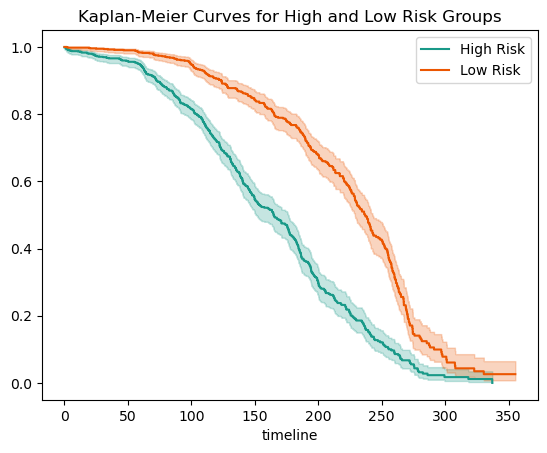

Log-rank test p-value: 3.785531055656777e-38


In [9]:
# Kaplan-Meier fit for High Risk and Low Risk groups
kmf_high = KaplanMeierFitter()
kmf_low = KaplanMeierFitter()

high_risk = significant_df[significant_df['risk_group'] == 'High Risk']
low_risk = significant_df[significant_df['risk_group'] == 'Low Risk']

# Fit data
T_high = high_risk['overall_survival_months']
E_high = high_risk['overall_survival']
kmf_high.fit(T_high, E_high, label='High Risk')

T_low = low_risk['overall_survival_months']
E_low = low_risk['overall_survival']
kmf_low.fit(T_low, E_low, label='Low Risk')

# # Plot KM curves with specified colors
ax = kmf_high.plot_survival_function(color='#199988')
kmf_low.plot_survival_function(ax=ax, color = '#EB5601')
plt.title("Kaplan-Meier Curves for High and Low Risk Groups")
plt.show()


# Log-rank test
results = lifelines.statistics.logrank_test(T_high, T_low, event_observed_A=E_high, event_observed_B=E_low)
print(f'Log-rank test p-value: {results.p_value}')


## Import Clinical Data

In [10]:
df_original_selected = df_original.iloc[:, :30]

df_original_selected = df_original_selected.drop(columns=['overall_survival', 'overall_survival_months'])

# Merge df_original_selected and significant_df on index
merged_df = pd.merge(df_original_selected, significant_df, left_index=True, right_index=True, how='inner')
merged_df.head(3)

,patient_id,age_at_diagnosis,type_of_breast_surgery,cancer_type,cancer_type_detailed,cellularity,chemotherapy,pam50_+_claudin-low_subtype,cohort,er_status_measured_by_ihc,...,smad4,ccnd2,rps6,pdgfb,jak2,rheb,ncoa3,akt1,risk_score,risk_group
0,0,75.65,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,NaN,0,claudin-low,1.0,Positve,...,0.2348,1.4313,0.8191,-0.0349,1.6186,0.7390,-0.2318,-1.1280,1.246588,High Risk
1,2,43.19,BREAST CONSERVING,Breast Cancer,Breast Invasive Ductal Carcinoma,High,0,LumA,1.0,Positve,...,0.8578,0.0546,1.4198,-0.3739,-0.0104,0.7496,-0.0219,0.0312,0.416135,High Risk
2,5,48.87,MASTECTOMY,Breast Cancer,Breast Invasive Ductal Carcinoma,High,1,LumB,1.0,Positve,...,1.4349,0.8958,1.3971,-1.6093,0.7379,1.0751,-0.2147,0.9269,0.497073,High Risk


## Correlation between the genetic attributes and the clinical characteristics

In [11]:
# Split the DataFrame into clinical and genetic data
clinical_data = merged_df.iloc[:, :32]  # first 32 columns are clinical
genetic_data = merged_df.iloc[:, 32:]   # columns after the first 32 are genetic

# Include the 'risk_group' column in clinical data for analysis
clinical_data['risk_group'] = merged_df['risk_group']

# List of clinical categorical variables to test
categorical_vars = clinical_data.select_dtypes(include=['object']).columns
continuous_vars = clinical_data.select_dtypes(include=['float']).columns  # adjust these to your dataset columns

# Analyzing categorical variables using Chi-square test
for var in categorical_vars:
    contingency_table = pd.crosstab(clinical_data['risk_group'], clinical_data[var])
    chi2, p, _, _ = chi2_contingency(contingency_table)
    if p < 0.005:
        print(f"Chi-square test for {var}: p-value = {p}")

Chi-square test for cellularity: p-value = 0.0007466258113839816
Chi-square test for pam50_+_claudin-low_subtype: p-value = 4.2450983904915786e-13
Chi-square test for er_status_measured_by_ihc: p-value = 6.779484743730048e-05
Chi-square test for er_status: p-value = 1.4757784643499847e-05
Chi-square test for integrative_cluster: p-value = 1.2594474443437397e-10
Chi-square test for 3-gene_classifier_subtype: p-value = 1.483061408338504e-08
Chi-square test for risk_group: p-value = 0.0


Certain molecular markers and clinical indices (like ER and PR status, certain genetic mutations, lymph node status, and specific prognostic indices) show strong associations with risk groups, indicating they are potential markers for more aggressive or less favorable disease outcomes.
Chi-Square Test Results:
- `pam50_+_claudin-low_subtype`: Extremely significant, indicating a strong association between this subtype and risk group.
- `er_status_measured_by_ihc` and `er_status`: Both show significant results, suggesting that estrogen receptor status is associated with risk groups.
- `integrative_cluster`: Significant, indicating that this classification correlates with the risk groups.
- `3-gene_classifier_subtype`: Highly significant, showing strong association.


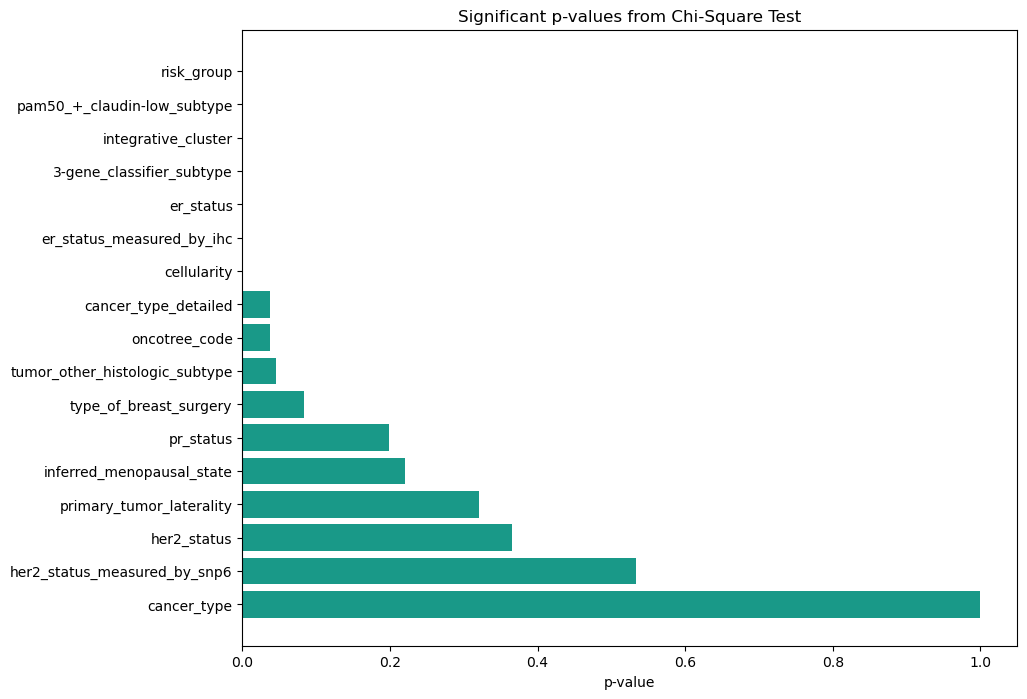

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, mannwhitneyu

# Split the DataFrame into clinical and genetic data
clinical_data = merged_df.iloc[:, :32]  # first 32 columns are clinical
genetic_data = merged_df.iloc[:, 32:]   # columns after the first 32 are genetic

# Include the 'risk_group' column in clinical data for analysis
clinical_data['risk_group'] = merged_df['risk_group']

# List of clinical categorical variables to test
categorical_vars = clinical_data.select_dtypes(include=['object']).columns
continuous_vars = clinical_data.select_dtypes(include=['float']).columns  # adjust these to your dataset columns

# Assuming 'clinical_data' and the variable lists 'categorical_vars' and 'continuous_vars' are already defined

# Store the results in a dictionary
p_values = {}

# Analyzing categorical variables using Chi-square test
for var in categorical_vars:
    contingency_table = pd.crosstab(clinical_data['risk_group'], clinical_data[var])
    chi2, p, _, _ = chi2_contingency(contingency_table)
#     if p < 0.005:
    p_values[f"{var}"] = p

# Create a bar graph
# Sort p-values by value
sorted_p_values = sorted(p_values.items(), key=lambda x: x[1])

# Unzip into labels and values
labels, values = zip(*sorted_p_values)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(labels, values, color='#199988')
plt.xlabel('p-value')
plt.title('Significant p-values from Chi-Square Test')
plt.gca().invert_yaxis()  # Invert y-axis to have the lowest p-values at the top
plt.show()
